In [1]:
#Install the Kaggle package
!pip install kaggle

In [2]:
# Create a folder for Kaggle credentials
!mkdir -p ~/.kaggle

# Copy the Kaggle API key file to the credentials folder
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Downloading the Eye Diseases Classification dataset from Kaggle
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 99% 731M/736M [00:03<00:00, 146MB/s]
100% 736M/736M [00:03<00:00, 206MB/s]


In [4]:
#Let's unzip the dataset
!unzip -q eye-diseases-classification.zip -d eye_disease_data

In [5]:
#importing important libraries
import os, glob, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
# Set a fixed seed so results stay consistent each time you run the code
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define dataset path, image size, batch size, and validation split ratio
DATA_ROOT = "/content/eye_disease_data/dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

Total normal images: 1074


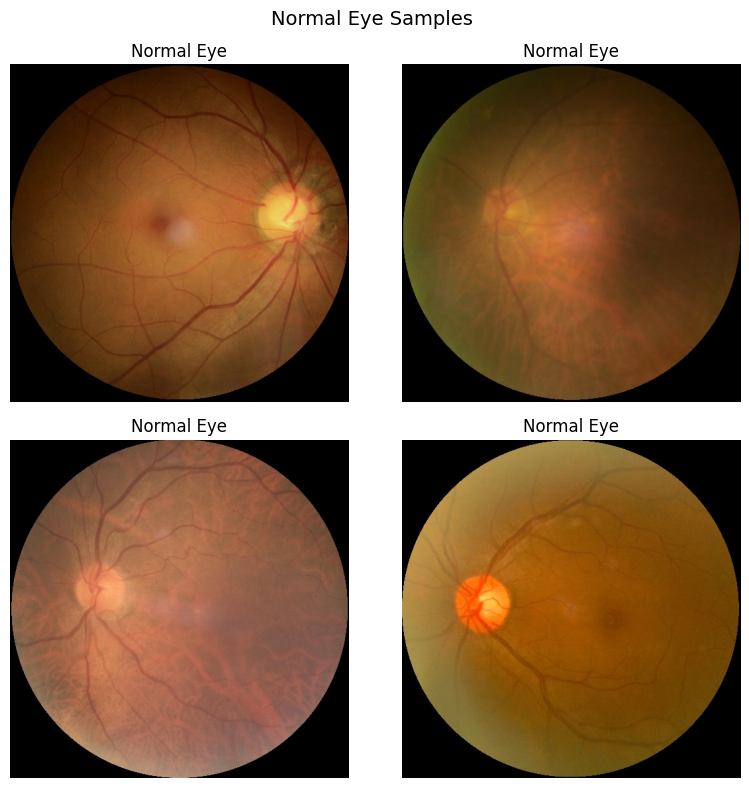

In [8]:
# Display first 4 normal eye images
normal_imgs = glob.glob(os.path.join(DATA_ROOT, "normal", "*.jpg"))
print("Total normal images:", len(normal_imgs))


normal_imgs = glob.glob(os.path.join(DATA_ROOT, "normal", "*.jpg"))

plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(mpimg.imread(normal_imgs[i]))
    plt.title("Normal Eye")
    plt.axis("off")

plt.suptitle("Normal Eye Samples ", fontsize=14)
plt.tight_layout()
plt.show()

Total cataract images: 938


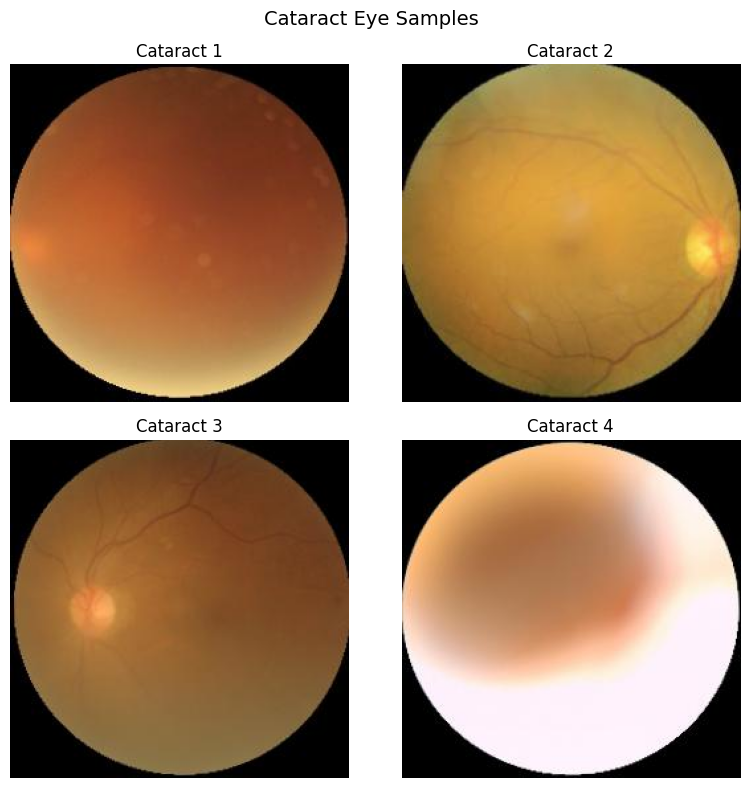

In [ ]:
# Display first 4 cataract eye images
cataract_imgs = glob.glob(os.path.join(DATA_ROOT, "cataract", "*.jpg"))
print("Total cataract images:", len(cataract_imgs))

plt.figure(figsize=(8, 8))

for i in range(4):
    img = mpimg.imread(cataract_imgs[i])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Cataract {i + 1}")
    plt.axis("off")

plt.suptitle("Cataract Eye Samples ", fontsize=14)
plt.tight_layout()
plt.show()

Total glaucoma images found: 906


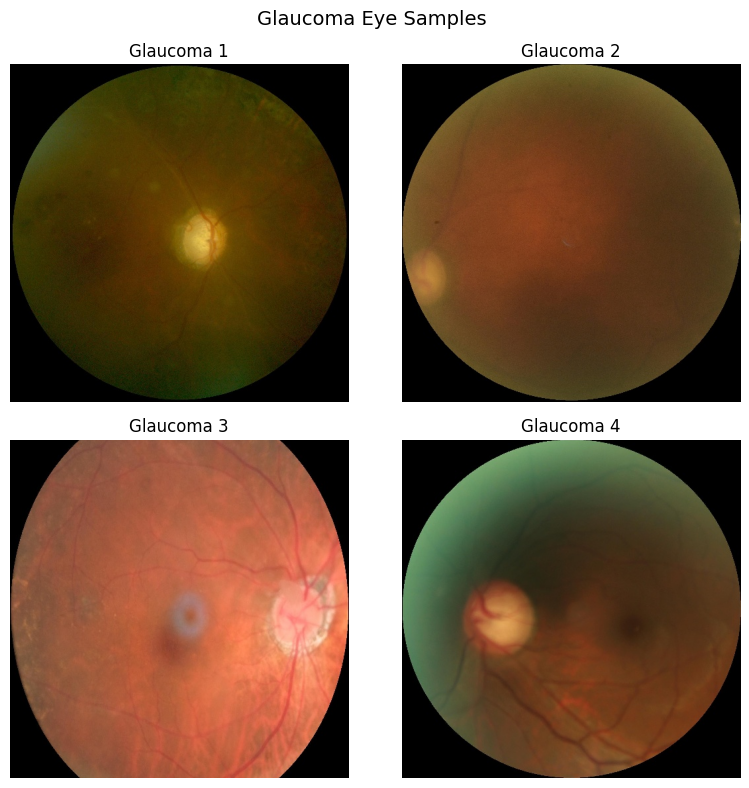

In [ ]:
glaucoma_imgs = glob.glob(os.path.join(DATA_ROOT, "glaucoma", "*.jpg"))
print("Total glaucoma images found:", len(glaucoma_imgs))

#Display first 4 glaucoma images
plt.figure(figsize=(8, 8))

for i in range(4):
    img = mpimg.imread(glaucoma_imgs[i])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Glaucoma {i + 1}")
    plt.axis("off")

plt.suptitle("Glaucoma Eye Samples ", fontsize=14)
plt.tight_layout()
plt.show()

Total diabetic retinopathy images: 1098


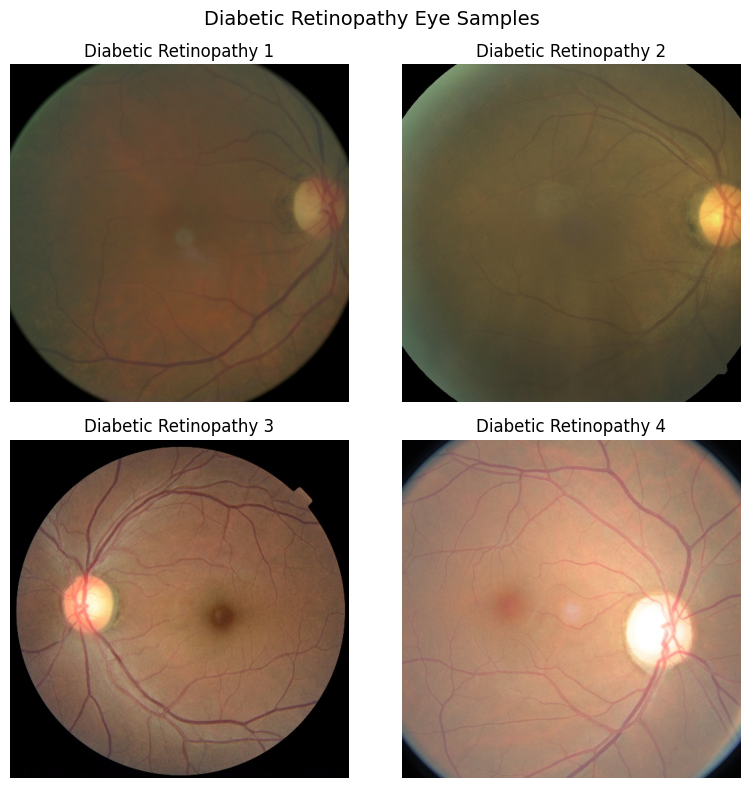

In [9]:
#Display first 4 diabetic retiopathy images
dr_imgs = glob.glob(os.path.join(DATA_ROOT, "diabetic_retinopathy", "*.jpeg"))
print("Total diabetic retinopathy images:", len(dr_imgs))


plt.figure(figsize=(8, 8))

for i in range(4):
    img = mpimg.imread(dr_imgs[i])
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Diabetic Retinopathy {i + 1}")
    plt.axis("off")

plt.suptitle("Diabetic Retinopathy Eye Samples ", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Load training images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Load validation images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


# Improve data loading performance with caching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
# Defining simple data augmentation by fliping and rotating images slightly
aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

rescale = layers.Rescaling(1./255)

In [ ]:
#build a CNN model for eye disease classification

model = keras.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    aug,
    rescale,

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

# Compile the model with Adam optimizer and accuracy metric
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train the model
EPOCHS = 12
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4825 - loss: 1.1351 - val_accuracy: 0.6738 - val_loss: 0.7771
Epoch 2/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.6647 - loss: 0.7619 - val_accuracy: 0.7628 - val_loss: 0.6006
Epoch 3/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7381 - loss: 0.6215 - val_accuracy: 0.7343 - val_loss: 0.7430
Epoch 4/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7659 - loss: 0.5542 - val_accuracy: 0.7758 - val_loss: 0.6743
Epoch 5/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7732 - loss: 0.5589 - val_accuracy: 0.8055 - val_loss: 0.4943
Epoch 6/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7930 - loss: 0.5128 - val_accuracy: 0.7829 - val_loss: 0.5941
Epoch 7/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7922 - loss: 0.5006 - val_accuracy: 0.8149 - val_loss: 0.4797
Epoch 8/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8113 - loss: 0.4643 - val_ac

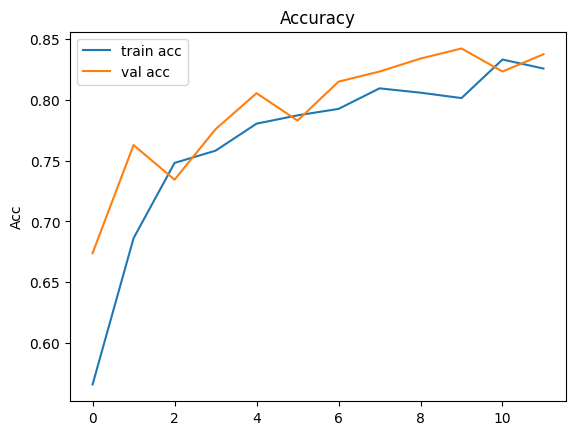

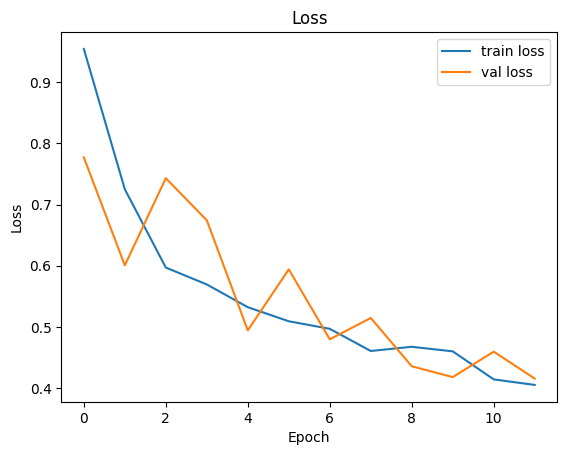

In [ ]:
# Extract training and validation accuracy/loss from model history
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

# Plot accuracy over epochs
plt.figure()
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.legend()
plt.show()

# Plot loss over epochs
plt.figure()
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Figure 1: The model’s accuracy improves steadily with each epoch, and both the training and validation lines move closely together, ending around 82%. This means the model is learning well without overfitting and starts to level off after a few rounds, showing it’s becoming stable and reliable.

Figure 2: The loss for both training and validation data drops quickly during the first few epochs, showing that the model is learning efficiently. After that, the curves flatten and stay close together, which means the model is stable and not overfitting. Overall, the steady decrease in loss reflects good optimization and consistent learning progress.

In [ ]:
# Check how well the model performed using the classification report and confusion matrix

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.87      0.67      0.76       204
diabetic_retinopathy       0.97      1.00      0.98       217
            glaucoma       0.76      0.76      0.76       201
              normal       0.77      0.90      0.83       221

            accuracy                           0.84       843
           macro avg       0.84      0.83      0.83       843
        weighted avg       0.84      0.84      0.83       843

Confusion Matrix:
 [[137   0  38  29]
 [  0 217   0   0]
 [ 16   1 153  31]
 [  5   6  11 199]]


#Transfer Learning - EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224)
num_classes = 4

# Base model
base_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
for layer in base_eff.layers:
    layer.trainable = False

# Head
x = GlobalAveragePooling2D()(base_eff.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output_eff = Dense(num_classes, activation='softmax')(x)

# Model
model_eff = Model(inputs=base_eff.input, outputs=output_eff)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_eff.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train
history_eff = model_eff.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 368ms/step - accuracy: 0.4970 - loss: 1.1366 - val_accuracy: 0.7794 - val_loss: 0.6426
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7259 - loss: 0.6794 - val_accuracy: 0.8244 - val_loss: 0.5142
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7907 - loss: 0.5593 - val_accuracy: 0.8505 - val_loss: 0.4495
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8339 - loss: 0.4843 - val_accuracy: 0.8707 - val_loss: 0.4038
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8266 - loss: 0.4552 - val_accuracy: 0.8802 - val_loss: 0.3743
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8417 - loss: 0.4220 - val_accuracy: 0.8956 - val_loss: 0.3566
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8505 - loss: 0.4085 - val_accuracy: 0.8921 - val_loss: 0.3454
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8618 - loss: 0.3775 - val_ac

In [ ]:
# Unfreeze the last 30 layers to fine-tune deeper parts of EfficientNet
for layer in base_eff.layers[-30:]:
    layer.trainable = True

model_eff.compile(optimizer=Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Add callbacks to stop training early and lower learning rate if validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

history_eff_ft = model_eff.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop, reduce_lr])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 62s 287ms/step - accuracy: 0.6898 - loss: 0.8233 - val_accuracy: 0.8731 - val_loss: 0.3497 - learning_rate: 1.0000e-05
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8069 - loss: 0.5975 - val_accuracy: 0.8885 - val_loss: 0.3613 - learning_rate: 1.0000e-05
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8512 - loss: 0.5006 - val_accuracy: 0.8956 - val_loss: 0.3494 - learning_rate: 1.0000e-05
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8620 - loss: 0.4467 - val_accuracy: 0.9004 - val_loss: 0.3265 - learning_rate: 1.0000e-05
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8672 - loss: 0.4068 - val_accuracy: 0.9063 - val_loss: 0.3038 - learning_rate: 1.0000e-05
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8740 - loss: 0.3804 - val_accuracy: 0.9075 - val_loss: 0.2871 - learning_rate: 1.0000e-05
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - a

In [ ]:
# Get true and predicted labels for the EfficientNet model
y_true_eff = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_eff = np.argmax(model_eff.predict(val_ds), axis=1)

# Print performance metrics
print("Classification Report (EfficientNet):\n",
      classification_report(y_true_eff, y_pred_eff, target_names=class_names))

print("Confusion Matrix (EfficientNet):\n",
      confusion_matrix(y_true_eff, y_pred_eff))

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step
Classification Report (EfficientNet):
                       precision    recall  f1-score   support

            cataract       0.91      0.93      0.92       204
diabetic_retinopathy       1.00      1.00      1.00       217
            glaucoma       0.88      0.85      0.87       201
              normal       0.89      0.91      0.90       221

            accuracy                           0.92       843
           macro avg       0.92      0.92      0.92       843
        weighted avg       0.92      0.92      0.92       843

Confusion Matrix (EfficientNet):
 [[189   0  10   5]
 [  0 216   0   1]
 [ 11   1 171  18]
 [  7   0  13 201]]


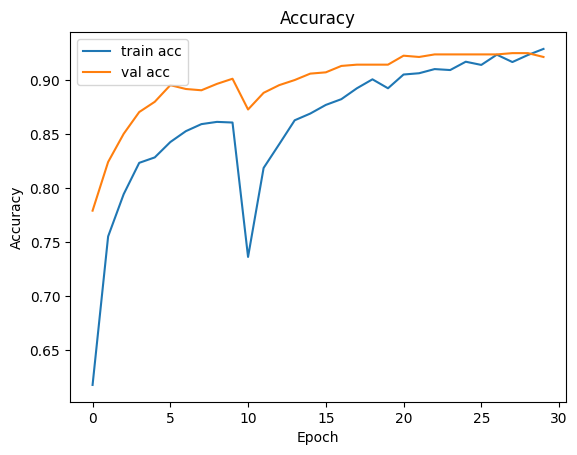

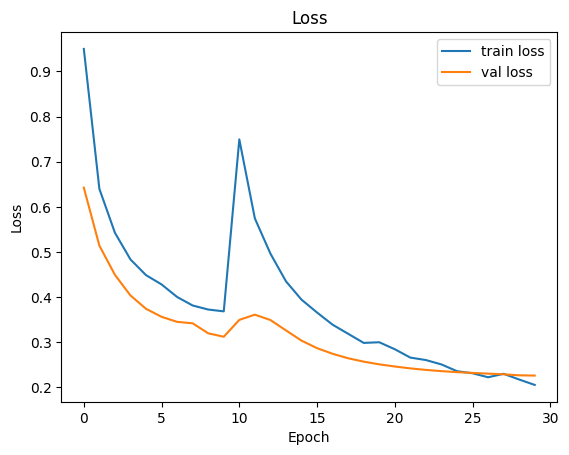

In [ ]:
# Combine histories
acc = history_eff.history.get("accuracy", []) + history_eff_ft.history.get("accuracy", [])
val_acc = history_eff.history.get("val_accuracy", []) + history_eff_ft.history.get("val_accuracy", [])
loss = history_eff.history.get("loss", []) + history_eff_ft.history.get("loss", [])
val_loss = history_eff.history.get("val_loss", []) + history_eff_ft.history.get("val_loss", [])

# Accuracy plot
plt.figure()
plt.plot(acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Figure 1: It can be clearly observed that both training and validation accuracy rise fast and stick close to each other, ending around 90%. That’s a good sign ,it means that the model is learning patterns that work on new images too. The curve flattens out near the end, showing it’s reached a stable, well-trained point.


Figure 2: The loss drops sharply at first, which means the model quickly figured out the basics. After that, both curves level off and stay close together, showing steady learning and no overfitting. The model learned efficiently and ended up performing reliably on both training and validation sets.

###After testing both models, the CNN I built from scratch did a decent job, hitting about 84% accuracy with a macro F1-score of 0.83. It was great at spotting diabetic retinopathy (basically perfect), but it had a tougher time with cataract and glaucoma, where the recall dropped to 0.67 and 0.76.

###The EfficientNet transfer learning model, on the other hand,did better. It reached 92% accuracy with a macro F1-score of 0.92, stayed consistent across all classes, and did amazing in predicting diabetic retinopathy aga§in with a perfect score. The predictions were more balanced and stable overall, without much drop in any category.

###In summary, while both models performed well, the transfer learning model with EfficientNet proved more reliable and consistent across all disease categories. It required less training effort, achieved higher accuracy, and showed stronger class-level balance making it the preferred choice for this eye disease classification task.

#Example Prediction

### We'll now test the trained model on a single image and predict the eye disease class

image link - https://images.medicinenet.com/images/slideshow/eye_diseases_and_cond_s3_glaucoma.jpg?resize=400px:*&output-quality=75

In [ ]:
!wget https://images.medicinenet.com/images/slideshow/eye_diseases_and_cond_s3_glaucoma.jpg?resize=400px:*&output-quality=75

/bin/bash: line 1: output-quality=75: command not found
--2025-11-09 21:55:09--  https://images.medicinenet.com/images/slideshow/eye_diseases_and_cond_s3_glaucoma.jpg?resize=400px:*
Resolving images.medicinenet.com (images.medicinenet.com)... 172.64.154.227, 104.18.33.29
Connecting to images.medicinenet.com (images.medicinenet.com)|172.64.154.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8226 (8.0K) [image/webp]
Saving to: ‘eye_diseases_and_cond_s3_glaucoma.jpg?resize=400px:*’

eye_diseases_and_co 100%[===================>]   8.03K  --.-KB/s    in 0s      

2025-11-09 21:55:09 (97.9 MB/s) - ‘eye_diseases_and_cond_s3_glaucoma.jpg?resize=400px:*’ saved [8226/8226]



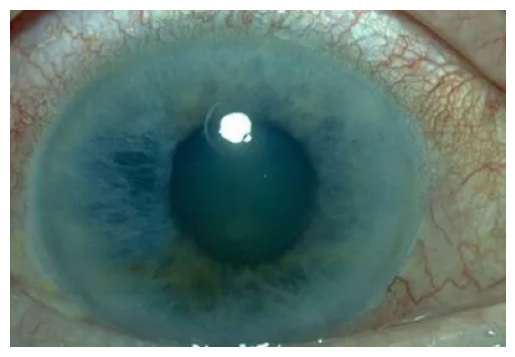

In [ ]:
# Display the image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img('/content/eye_pred.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
#Preprocessing

# Resize and prepare the image for prediction
import tensorflow as tf
import numpy as np

IMG_SIZE = (224, 224)

img = image.img_to_array(img) / 255.0
img = tf.image.resize(img, IMG_SIZE)
img = tf.expand_dims(img, axis=0)

print("Image Shape:", img.shape)


Image Shape: (1, 224, 224, 3)


In [ ]:
# Predict the class of the image using the trained model
prediction = np.argmax(model_eff.predict(img), axis=1)[0]
predicted_label = class_names[prediction]

print(f"The predicted label is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
The predicted label is: glaucoma


# Thank you